## Этим проектом выявляем наиболее перспективный тариф для телеком компании

#### Описание проекта
В компании «Мегалайн» — федерального оператора сотовой связи клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.  
Проанализируем поведение клиентов, сделаем вывод — какой тариф лучше оставить для дальнейшего развития компании. 


#### Описание данных

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана
- Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок
- Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение
- Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя
- Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Примечание. Если объединение таблиц методом merge приводит к ошибке dead kernell, примените метод join — это облегчит нагрузку на Jupyter Notebook.**

In [1]:
import pandas as pd
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from pymystem3 import Mystem
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)




In [2]:
os.getcwd()

'/home/user-0-13339652/work'

### Ссылки на основные действия <a id="cell28"></a>
0. [Оценим количество строк и столбцов в таблице](#cell13)
0. [Первоначальные действия проверяем названия колонок, структуру таблицы, состав таблицы, пустых строк и проч](#cell0)
1. [Округляем в большую сторону](#cell1)
2. [Удаляем столбец](#cell2)
3. [Вычисляем усы](#cell3)
3. [Меняем название столбца](#cell4)
4. [Стоим диаграмму и ящик с усами и скрипку с усами](#cell5)
5. [Обединяем таблицы с join](#cell6)
5. [Обединяем таблицы с merge](#cell7)
6. [Меняем значение в столбце с одного на другой напр. отрицательные значения на нулевые](#cell8)
7. [Делаем сводные талблицы](#cell9)
8. [Доступ к сводной таблице по индексу](#cell10)
9. [Строим двойную диаграмму-гистограмму](#cell11)
10. [Строим двойную диаграмму, через сводную таблицу](#cell20)
11. [Замена элементов столбца](#cell12)
11. [Применяем `.describe`  к нечисловым полям](#cell14)
12. [Смотрим строку в таблице по конкретному значению](#cell15)
13. [Смотрим тип строк в таблице](#cell16)
14. [Делаем сводные талблицы применяем два значения к одному стобцу](#cell17)
15. [формируем таблицу только с нужными столбцами](#cell18)
15. [Сводная таблица Чтобы обращаться к стобцам как к обычному столбцу reset_index.](#cell19)
16. [Посмотрим количество уникальных элементов.](#cell21)
17. [Замена NaN меняем его на 0.](#cell22)
18. [Замена пропуски на ноду.](#cell23)

 **Замена элементов столбца** <a id="cell12"></a>

In [3]:
#for column_name in ["product_discount", "total_price"]:
    #order[column_name] = order[column_name].str.replace(',', '.')

# Шаг 1. Откройте файл с данными и изучите общую информацию

In [4]:
call = pd.read_csv('/datasets/calls.csv')
inter = pd.read_csv('/datasets/internet.csv')
mess = pd.read_csv('/datasets/messages.csv')
tarif = pd.read_csv('/datasets/tariffs.csv')
user = pd.read_csv('/datasets/users.csv')


### Смотрим название колонок на корректность, структуру таблицы и  инфо на пропуски и типы данных и наличие дубликатов

**calls (информация о звонках):** 
1. проверяем коректность названия колонок
2. Смотрим структуру таблицы
3. Смотрим состав таблицы, формат столбцов, наличие пустых строк
4. Проверяем наличие дубликатов
5. Проверяем наличие нулевых обьектов

**Оценим количество строк и столбцов в таблице**<a id="cell13"></a>

In [5]:
display(call.shape)
display(inter.shape)
display(mess.shape)
display(tarif.shape)
user.shape

(202607, 4)

(149396, 5)

(123036, 3)

(2, 8)

(500, 8)

In [6]:
def total_info(data):
    for info in ['columns','head()','info()','duplicated().sum()','isnull().sum()','isna().sum()']:
        return display(data.info)

In [7]:
total_info(call)

<bound method DataFrame.info of               id   call_date  duration  user_id
0         1000_0  2018-07-25      0.00     1000
1         1000_1  2018-08-17      0.00     1000
2         1000_2  2018-06-11      2.85     1000
3         1000_3  2018-09-21     13.80     1000
4         1000_4  2018-12-15      5.18     1000
...          ...         ...       ...      ...
202602  1499_215  2018-12-26      0.76     1499
202603  1499_216  2018-10-18     18.83     1499
202604  1499_217  2018-11-10     10.81     1499
202605  1499_218  2018-10-06      4.27     1499
202606  1499_219  2018-12-14     19.62     1499

[202607 rows x 4 columns]>

In [8]:
display(call.columns) # название колонок
display(call.head())# структуру таблицы
display(call.info())# состав таблицы, формат столбцов, наличие пустых строк
display(call.duplicated().sum()) # наличие дубликатов
display(call.isnull().sum()) # наличие нулевых обьектов
display(call.isna().sum())# наличие пропусков

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

0

id           0
call_date    0
duration     0
user_id      0
dtype: int64

id           0
call_date    0
duration     0
user_id      0
dtype: int64

**информация о траффике интернета** <a id="cell0"></a>

In [9]:
display(inter.columns)
display(inter.head())
display(inter.info())
display(inter.duplicated().sum())
display(inter.isnull().sum())
display(inter.isna().sum())

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

0

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

**информация о сообщениях**

In [10]:
display(mess.columns)
display(mess.head())
display(mess.info())
display(mess.duplicated().sum())
display(mess.isnull().sum())

Index(['id', 'message_date', 'user_id'], dtype='object')

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

0

id              0
message_date    0
user_id         0
dtype: int64

**информация о тарифах**

In [11]:
display(tarif.columns)
display(tarif.head())
display(tarif.info())
display(tarif.duplicated().sum())
display(mess.isnull().sum())

Index(['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff_name'], dtype='object')

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

0

id              0
message_date    0
user_id         0
dtype: int64

**информация о пользователях**

In [12]:
display(user.columns)
display(user.head())
display(user.info())
display(user.duplicated().sum())
display(user.isnull().sum())

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff'], dtype='object')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

0

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

# Шаг 2. Подготовьте данные

<div class="alert alert-success" role="alert">
    <strong>Информация о звонках call</strong> 
    </div>

**приводим даты к формату даты,  поскольку в тарифах минуты округляются в большую сторону округляем столбец duration  до целого в большую сторону**

In [13]:
display(call.head())
call.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


**приводим даты к формату даты,**

In [14]:
call['call_date'] = pd.to_datetime(call['call_date'])
call.dtypes

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

**поменяем дату на номер месяца все равно год нам известен а число не нужно, а оперировать будет проще**

In [15]:
call['call_date'] = call['call_date'].dt.month
call.head()


,id,call_date,duration,user_id
0,1000_0,7,0.00,1000
1,1000_1,8,0.00,1000
2,1000_2,6,2.85,1000
3,1000_3,9,13.80,1000
4,1000_4,12,5.18,1000


**переименуем столбец с датой** <a id="cell4"></a>

In [16]:
call = call.rename(columns={"call_date": "month"})
call.head()

,id,month,duration,user_id
0,1000_0,7,0.00,1000
1,1000_1,8,0.00,1000
2,1000_2,6,2.85,1000
3,1000_3,9,13.80,1000
4,1000_4,12,5.18,1000


**округляем значения  столбца duration до целого в большую сторону**<a id="cell1"></a>

можно так билиотекой math.ceil

In [17]:
def _round(row):
    row_round = math.ceil(row)
    return row_round


а можно и так средствами питон

In [18]:
# def _round(row):
#     if row != 0.00:
#         row_round = (row//1)+1
#         return row_round

In [19]:
call['duration'] = call['duration'].apply(_round)


**и так как вместо 0 функцимя возвращает NaN меняем его на 0**<a id="cell22"></a>

In [20]:
# call['duration'] = call['duration'].fillna(0)

In [21]:
call.head()

,id,month,duration,user_id
0,1000_0,7,0,1000
1,1000_1,8,0,1000
2,1000_2,6,3,1000
3,1000_3,9,14,1000
4,1000_4,12,6,1000


**Смотрим строку по значению** <a id="cell15"></a>

In [22]:
call[call['id'] == '1000_3']

,id,month,duration,user_id
3,1000_3,9,14,1000


**Смотрим тип строк в таблице**<a id="cell16"></a>

In [23]:
call.dtypes

id          object
month        int64
duration     int64
user_id      int64
dtype: object

In [24]:
call['duration'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

**Применяем `.describe`  к нечисловым полям**<a id="cell14"></a>

In [25]:
call.select_dtypes(include=["object", "datetime"]).describe()

,id
count,202607
unique,202607
top,1449_287
freq,1


**Строим диаграмму и 2 ящика с усами** <a id="cell5"></a>

Text(0.5, 0, 'Длительность')

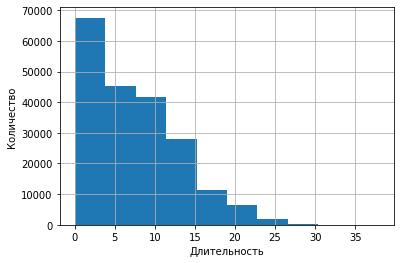

In [26]:
call['duration'].hist()
plt.ylabel('Количество')
plt.xlabel('Длительность')

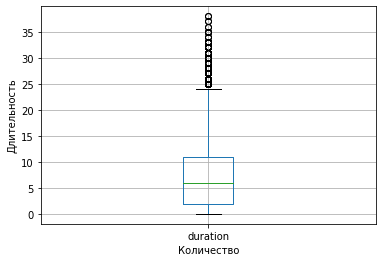

In [27]:
call.boxplot('duration')
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.show()

Text(0.5, 0, 'Длительность')

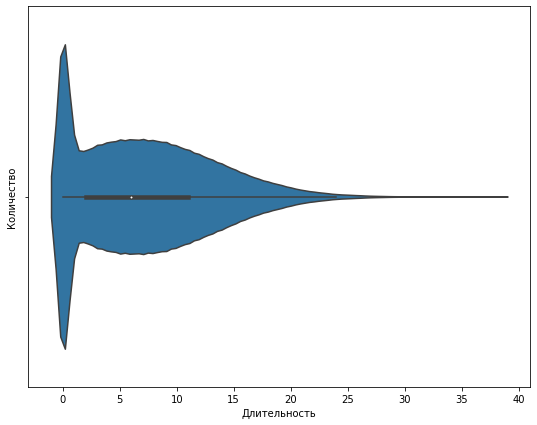

In [28]:
fig, ax = plt.subplots(figsize =(9, 7))
sns.violinplot(ax = ax, x='duration', data=call);
plt.ylabel('Количество')
plt.xlabel('Длительность')

In [29]:
display((call['duration'] > 24).sum())

1041

<a id="cell3"></a> **Вычисляем предел усов**

In [30]:
q1 = call['duration'].quantile(0.25)
q3 = call['duration'].quantile(0.75)
iqr = q3 - q1

mistash_down = q1 - 1.5 * iqr
mistash_up = q3 + 1.5 * iqr
print('Нижний ус = ', mistash_down)
print('Верхний ус = ', mistash_up)
print('Сколько выше верхнего уса - ', (call['duration'] > mistash_up).sum())
print('Процент значений выше верхнего уса - ', ((call['duration'] > mistash_up).sum()/ call['duration'].count()*100),'%')
print('Процент значений ниже нижнего уса - ', ((call['duration'] > mistash_down).sum()/ call['duration'].count()*100),'%')

Нижний ус =  -11.5
Верхний ус =  24.5
Сколько выше верхнего уса -  1041
Процент значений выше верхнего уса -  0.5138025833263411 %
Процент значений ниже нижнего уса -  100.0 %


**формируем сводную таблицу по звонкам и суммируем длительность по числам**

In [31]:
call_user = call.groupby(['user_id', 'month']).agg({'duration':'sum'})
display(call_user)

duration
user_id month          
1000    5           159
        6           172
        7           340
        8           408
        9           466
...                 ...
1498    10          247
1499    9            70
        10          449
        11          612
        12          492

[3174 rows x 1 columns]

**Длительность многих звонков — 0.0 минут. Так как эти звонки никак не  тарифицируются и на прибыль компании влияния не оказывают удаляем их как ненужные**

количество нулевых звонков

In [32]:
display((call['duration'] == 0).sum())
display(call['duration'].count())
print('Процент звонков с нулевой длительностью-',((call['duration'] == 0).sum()/call['duration'].count())*100, '%' )

39613

202607

Процент звонков с нулевой длительностью- 19.551644316336553 %


In [33]:
call = call[call['duration'] > 0]
display((call['duration'] == 0).sum())
display(call['duration'].count())

0

162994

**снова строим диаграммы**

Text(0.5, 0, 'Длительность')

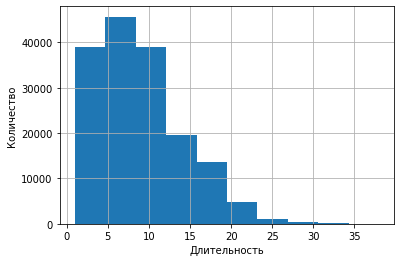

In [34]:
call['duration'].hist()
plt.ylabel('Количество')
plt.xlabel('Длительность')

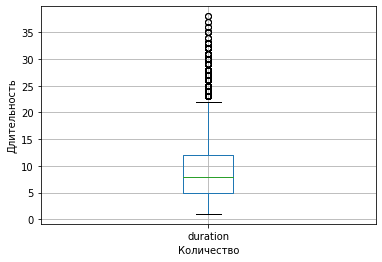

In [35]:
call.boxplot('duration')
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.show()

Text(0.5, 0, 'Длительность')

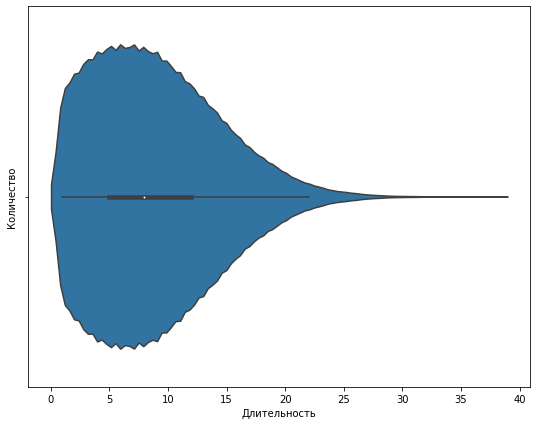

In [36]:
fig, ax = plt.subplots(figsize =(9, 7))

sns.violinplot(ax = ax, x='duration', data=call);
plt.ylabel('Количество')
plt.xlabel('Длительность')

<div class="alert alert-success" role="alert">
    <strong>inter (информация об интернет-сессиях):</strong> информация
    </div>

In [37]:
display(inter.head())
inter.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


**приводим даты 'session_date' к формату даты**

In [38]:
inter['session_date'] = pd.to_datetime(inter['session_date'])
inter.dtypes

Unnamed: 0               int64
id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

**Unnamed: 0 не нужный столбец не несущий никакой информации удаляем его**<a id="cell2"></a>

In [39]:
inter = inter.drop(columns = ['Unnamed: 0'])
inter.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


**округляем мб до целого в большую сторону**

In [40]:
def _round_inter(row):
    row_round = math.ceil(row)
    return row_round


In [41]:
inter['mb_used'] = inter['mb_used'].apply(_round_inter)
inter.head()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


**всесто полной даты указываем месяц**

In [42]:
inter['session_date'] = inter['session_date'].dt.month
inter.head()

,id,mb_used,session_date,user_id
0,1000_0,113,11,1000
1,1000_1,1053,9,1000
2,1000_2,1198,6,1000
3,1000_3,551,8,1000
4,1000_4,303,9,1000


**переименуем столбец с датой**

In [43]:
inter = inter.rename(columns={"session_date": "month"})
inter.head()

,id,mb_used,month,user_id
0,1000_0,113,11,1000
1,1000_1,1053,9,1000
2,1000_2,1198,6,1000
3,1000_3,551,8,1000
4,1000_4,303,9,1000


**формируем сводную таблицу по юзерам и суммируем потраченный траффик**

In [44]:
inter_user = inter.groupby(['user_id', 'month']).agg({'mb_used':'sum'})
display(inter_user)

mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581
...                ...
1498    10       20604
1499    9         1848
        10       17809
        11       17984
        12       13077

[3203 rows x 1 columns]

In [45]:
inter['mb_used'].describe()

count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64

**Диаграммы**

In [1]:
inter['mb_used'].hist()
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')

NameError: name 'inter' is not defined

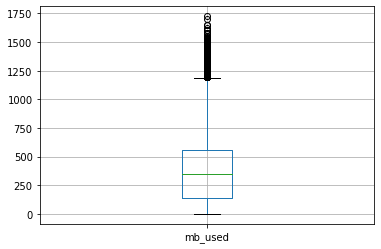

In [47]:
inter.boxplot('mb_used')
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.show()

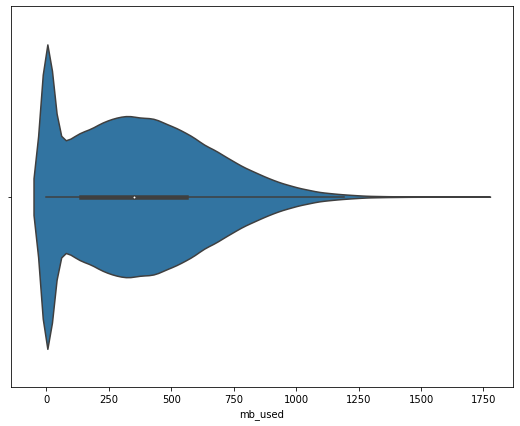

In [48]:
fig, ax = plt.subplots(figsize =(9, 7))
sns.violinplot(ax = ax, x='mb_used', data=inter);
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')

**Вычисляем предел усов**

In [49]:
q1 = inter['mb_used'].quantile(0.25)
q3 = inter['mb_used'].quantile(0.75)
iqr = q3 - q1
mistash_down = q1 - 1.5 * iqr
mistash_up = q3 + 1.5 * iqr
print('Нижний ус = ', mistash_down)
print('Верхний ус = ', mistash_up)
print('Сколько выше верхнего уса - ', (call['duration'] > mistash_up).sum())
print('Процент значений выше верхнего уса - ', ((inter['mb_used'] > mistash_up).sum()/ inter['mb_used'].count()*100),'%')
print('Процент значений ниже нижнего уса - ', ((inter['mb_used'] > mistash_down).sum()/ inter['mb_used'].count()*100),'%')

Нижний ус =  -492.5
Верхний ус =  1191.5
Сколько выше верхнего уса -  0
Процент значений выше верхнего уса -  0.366140994404134 %
Процент значений ниже нижнего уса -  100.0 %


**Количество клиентов с нулевым траффиком**  
**Так как этот траффик никак не тарифицируются и на прибыль компании влияния не оказывают удаляем их как ненужный** 

In [50]:
display((inter['mb_used'] == 0).sum())
display(inter['mb_used'].count())
print('Процент клиентов с нулевым траффиком-',((inter['mb_used'] == 0).sum()/inter['mb_used'].count())*100, '%' )

19598

149396

Процент клиентов с нулевым траффиком- 13.118155773916303 %


In [51]:
inter = inter[inter['mb_used'] > 0]
display((inter['mb_used'] == 0).sum())
display(inter['mb_used'].count())

0

129798

**снова смотрим диаграммы**

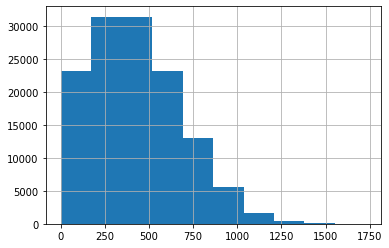

In [52]:
inter['mb_used'].hist()
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')

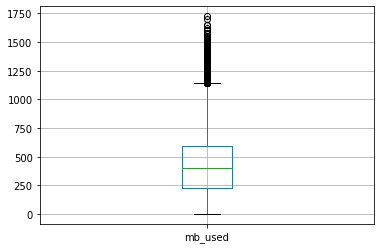

In [53]:
inter.boxplot('mb_used')
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')
plt.show()

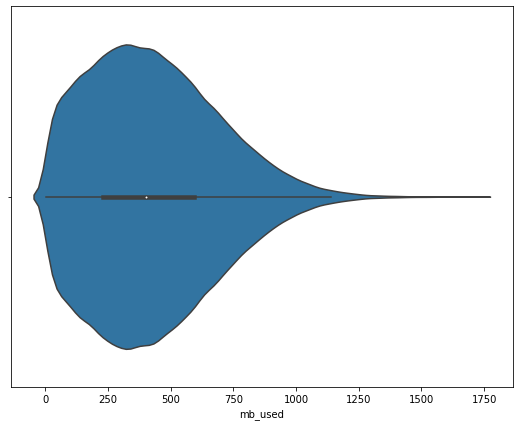

In [54]:
fig, ax = plt.subplots(figsize =(9, 7))
sns.violinplot(ax = ax, x='mb_used', data=inter);
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')

<div class="alert alert-success" role="alert">
    <strong>Таблица mess (информация о сообщениях)</strong> 
    </div>

In [55]:
display(mess.head())
mess.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


**исправляем формат даты и приводим ёе к месяцу**

In [56]:
mess['message_date'] = pd.to_datetime(mess['message_date'])
mess.dtypes

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

In [57]:
mess['message_date'] = mess['message_date'].dt.month
mess.head()

,id,message_date,user_id
0,1000_0,6,1000
1,1000_1,10,1000
2,1000_2,8,1000
3,1000_3,6,1000
4,1000_4,12,1000


In [58]:
mess = mess.rename(columns={"message_date": "month"})
mess.head()

,id,month,user_id
0,1000_0,6,1000
1,1000_1,10,1000
2,1000_2,8,1000
3,1000_3,6,1000
4,1000_4,12,1000


<div class="alert alert-success" role="alert">
    <strong>Таблица user (информация о пользователях): </strong> 
    </div>

**churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

In [59]:
display(user.head())
user.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


**исправляем формат даты и приводим ёе к месяцу**

In [60]:
user['reg_date'] = pd.to_datetime(user['reg_date'])
user['reg_date'] = user['reg_date'].dt.month
#user = user.rename(columns={"reg_date": "month"})
user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,5,ultra
1,1001,41,NaN,Москва,Иван,Ежов,11,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,6,smart
3,1003,23,NaN,Москва,Белла,Белякова,8,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,5,ultra


## Вывод:  
### Исправлен формат даты  и заменен на более удобный, удален ненужный столбец, удалены за ненадобностью нулевые значения, определнные выбросы не бы удалены так как занимают ничтожно малый процент, распределения судя по диаграммам соответствуют распределению Пуассона, что нормально

## Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-- - трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

<div class="alert alert-success" role="alert"><a id="cell28"></a>
    <strong>Количество сделанных звонков и израсходованных минут разговора по месяцам;</strong> 
    </div>

**делаем сводные таблицы по сумме и их среднему**<a id="cell17"></a>

In [61]:
call_user = call.groupby(['user_id', 'month']).agg({'duration':['sum', 'mean']})
call_user.columns = ['call_sum', 'call_mean']
display(call_user)
# call_user3 = call.groupby(['user_id', 'month']).agg({'duration':'np.var()'})
# call_user2.columns = ['call_mean']
# display(call_user2)

call_sum  call_mean
user_id month                     
1000    5           159   9.352941
        6           172   6.142857
        7           340   8.292683
        8           408   9.714286
        9           466  10.130435
...                 ...        ...
1498    10          247   8.233333
1499    9            70   8.750000
        10          449  10.204545
        11          612   9.870968
        12          492   8.785714

[3168 rows x 2 columns]

<div class="alert alert-success" role="alert">
    <strong>Kоличество отправленных сообщений по месяцам;</strong> 
    </div>

In [62]:
display(mess.head())

,id,month,user_id
0,1000_0,6,1000
1,1000_1,10,1000
2,1000_2,8,1000
3,1000_3,6,1000
4,1000_4,12,1000


In [63]:
mess_user = mess.groupby(['user_id', 'month']).agg({'user_id':'count'})
mess_user.columns = ['mess_sum']
display(mess_user)


mess_sum
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

In [64]:
mess_user.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2717 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
mess_sum    2717 non-null int64
dtypes: int64(1)
memory usage: 32.7 KB


<div class="alert alert-success" role="alert">
  <strong>Объем израсходованного интернет-трафика по месяцам;</strong> 
    </div>

In [65]:
inter.head()
inter_user = inter.groupby(['user_id', 'month']).agg({'mb_used':['sum', 'mean']})
inter_user.columns = ['inter_sum', 'inter_mean']


In [66]:
display(inter_user)

inter_sum  inter_mean
user_id month                       
1000    5           2256  564.000000
        6          23257  528.568182
        7          14016  500.571429
        8          14070  521.111111
        9          14581  583.240000
...                  ...         ...
1498    10         20604  420.489796
1499    9           1848  462.000000
        10         17809  414.162791
        11         17984  461.128205
        12         13077  326.925000

[3201 rows x 2 columns]

<div class="alert alert-success" role="alert">
    <strong>Тариф и город пользователя user</strong> 
    </div>

In [67]:
user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,5,ultra
1,1001,41,NaN,Москва,Иван,Ежов,11,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,6,smart
3,1003,23,NaN,Москва,Белла,Белякова,8,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,5,ultra


**формируем таблицу только с нужными столбцами**<a id="cell18"></a>

In [68]:
user_tarif_city = user.loc[:,['user_id', 'city', 'tariff' ]]
#user_tarif_city = user.groupby(['user_id']).agg({ 'city':'value_counts', 'tariff':'count'})
display(user_tarif_city.head())

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


**Формируем общую своднуб таблицу склеиваем join**<a id="cell7"></a>

In [69]:
df = call_user.join(inter_user, on=['user_id', 'month'])

display(df)


call_sum  call_mean  inter_sum  inter_mean
user_id month                                            
1000    5           159   9.352941     2256.0  564.000000
        6           172   6.142857    23257.0  528.568182
        7           340   8.292683    14016.0  500.571429
        8           408   9.714286    14070.0  521.111111
        9           466  10.130435    14581.0  583.240000
...                 ...        ...        ...         ...
1498    10          247   8.233333    20604.0  420.489796
1499    9            70   8.750000     1848.0  462.000000
        10          449  10.204545    17809.0  414.162791
        11          612   9.870968    17984.0  461.128205
        12          492   8.785714    13077.0  326.925000

[3168 rows x 4 columns]

In [70]:
df = df.join(mess_user, on=['user_id', 'month'])
display(df)


call_sum  call_mean  inter_sum  inter_mean  mess_sum
user_id month                                                      
1000    5           159   9.352941     2256.0  564.000000      22.0
        6           172   6.142857    23257.0  528.568182      60.0
        7           340   8.292683    14016.0  500.571429      75.0
        8           408   9.714286    14070.0  521.111111      81.0
        9           466  10.130435    14581.0  583.240000      57.0
...                 ...        ...        ...         ...       ...
1498    10          247   8.233333    20604.0  420.489796      42.0
1499    9            70   8.750000     1848.0  462.000000      11.0
        10          449  10.204545    17809.0  414.162791      48.0
        11          612   9.870968    17984.0  461.128205      59.0
        12          492   8.785714    13077.0  326.925000      66.0

[3168 rows x 5 columns]

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3168 entries, (1000, 5) to (1499, 12)
Data columns (total 5 columns):
call_sum      3168 non-null int64
call_mean     3168 non-null float64
inter_sum     3155 non-null float64
inter_mean    3155 non-null float64
mess_sum      2673 non-null float64
dtypes: float64(4), int64(1)
memory usage: 137.1 KB


<div class="alert alert-info">
    <strong> Обнаружили пропуски в данных по смс </strong> </div>

In [72]:
df['mess_sum'].isna().sum() 

495

In [73]:
df['inter_sum'].isna().sum() 

13

In [74]:
df['inter_mean'].isna().sum() 

13

In [75]:
df['mess_sum'].describe()

count    2673.000000
mean       45.020202
std        34.274773
min         1.000000
25%        19.000000
50%        38.000000
75%        63.000000
max       224.000000
Name: mess_sum, dtype: float64

<div class="alert alert-info">
    <strong>Думаю это люди которые не отправляют смс вообще поэтому меняем значения на ноль и так как 13 значений ни на что не влияют 'inter_mean', 'mess_sum' их тоже</strong> </div>

In [76]:
df['mess_sum'].fillna(0, inplace=True)
df['inter_mean'].fillna(0, inplace=True)
df['inter_sum'].fillna(0, inplace=True)

In [77]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3168 entries, (1000, 5) to (1499, 12)
Data columns (total 5 columns):
call_sum      3168 non-null int64
call_mean     3168 non-null float64
inter_sum     3168 non-null float64
inter_mean    3168 non-null float64
mess_sum      3168 non-null float64
dtypes: float64(4), int64(1)
memory usage: 137.1 KB


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3168 entries, (1000, 5) to (1499, 12)
Data columns (total 5 columns):
call_sum      3168 non-null int64
call_mean     3168 non-null float64
inter_sum     3168 non-null float64
inter_mean    3168 non-null float64
mess_sum      3168 non-null float64
dtypes: float64(4), int64(1)
memory usage: 137.1 KB


In [79]:
display(df.head(3) )
display(user_tarif_city.head(3))

call_sum  call_mean  inter_sum  inter_mean  mess_sum
user_id month                                                      
1000    5           159   9.352941     2256.0  564.000000      22.0
        6           172   6.142857    23257.0  528.568182      60.0
        7           340   8.292683    14016.0  500.571429      75.0

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart


**Присоеденяем таблицу с помощью merge**<a id="cell7"></a>

**смотрим** `reset_index()` `у тебя в одной таблице два столбца в индексе, ты присоединяешь вторую таблицу по одному из них. При этом Пандас автоматически удаляет из индекса второй столбце. Попробуй сделать так: new_data.reset_index().merge(...)`

<div class="alert alert-info">
    <strong>сорри да это я сам себе пямятки оставляю чтоб не забыть, думал ревьюверу не помешает а мне полезно :)))</strong> </div>

In [80]:
#df = df.join(user_tarif_city, on=['user_id'])
df_total = df.reset_index().merge(user_tarif_city, on=['user_id'], how='left')
display(df_total .head(10))


,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff
0,1000,5,159,9.352941,2256.0,564.000000,22.0,Краснодар,ultra
1,1000,6,172,6.142857,23257.0,528.568182,60.0,Краснодар,ultra
2,1000,7,340,8.292683,14016.0,500.571429,75.0,Краснодар,ultra
3,1000,8,408,9.714286,14070.0,521.111111,81.0,Краснодар,ultra
4,1000,9,466,10.130435,14581.0,583.240000,57.0,Краснодар,ultra
5,1000,10,350,7.954545,14717.0,545.074074,73.0,Краснодар,ultra
6,1000,11,338,9.135135,14768.0,642.086957,58.0,Краснодар,ultra
7,1000,12,333,8.763158,9827.0,517.210526,70.0,Краснодар,ultra
8,1001,11,430,9.555556,18452.0,392.595745,0.0,Москва,smart
9,1001,12,414,8.808511,14053.0,401.514286,0.0,Москва,smart


In [81]:
display(tarif.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [82]:
tarif = tarif.rename(columns={"tariff_name": "tariff"})
display(tarif.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [83]:
df_total = df_total.reset_index().merge(tarif, on=['tariff'], how='left')
display(df_total.head())



,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,0,1000,5,159,9.352941,2256.0,564.000000,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1,1000,6,172,6.142857,23257.0,528.568182,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,2,1000,7,340,8.292683,14016.0,500.571429,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,3,1000,8,408,9.714286,14070.0,521.111111,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,4,1000,9,466,10.130435,14581.0,583.240000,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [84]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 17 columns):
index                    3168 non-null int64
user_id                  3168 non-null int64
month                    3168 non-null int64
call_sum                 3168 non-null int64
call_mean                3168 non-null float64
inter_sum                3168 non-null float64
inter_mean               3168 non-null float64
mess_sum                 3168 non-null float64
city                     3168 non-null object
tariff                   3168 non-null object
messages_included        3168 non-null int64
mb_per_month_included    3168 non-null int64
minutes_included         3168 non-null int64
rub_monthly_fee          3168 non-null int64
rub_per_gb               3168 non-null int64
rub_per_message          3168 non-null int64
rub_per_minute           3168 non-null int64
dtypes: float64(4), int64(11), object(2)
memory usage: 445.5+ KB


<div class="alert alert-info">
    <strong>все проверял на самом деле удалил просто очень громоздко выглядело</strong> </div>

**Стоимость rub_per_gb за Гигабайт переведем за мегабайт**

In [85]:
df_total['inter_sum']=df_total['inter_sum']/1024
df_total['mb_per_month_included']=df_total['mb_per_month_included']/1024
df_total = df_total.rename(columns={'rub_per_gb': 'rub_per_mb'})
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute
0,0,1000,5,159,9.352941,2.203125,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
1,1,1000,6,172,6.142857,22.711914,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
2,2,1000,7,340,8.292683,13.687500,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
3,3,1000,8,408,9.714286,13.740234,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
4,4,1000,9,466,10.130435,14.239258,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1


<div class="alert alert-info">
    <strong>в таком случае я первожу inter_sum и mb_per_month_included в Гб и округляю до большего inter_sum и потом цена у нас пересчитывается авторматом </strong>

извини , не стал я имена столбцов корректно менять надо будет исправлять ниже, а по времени цейнот , но я знаю что надо :))) </div>

<div class="alert alert-info">
    <strong>меняем NaN на ноль</strong> </div>
    уже не надо выше все поменяли

In [86]:
df_total['inter_sum'].fillna(0, inplace=True)

<div class="alert alert-info">
    <strong>округляем inter_sum до большего</strong> </div>

In [87]:
def _round(row):
    row_round = math.ceil(row)
    return row_round
df_total['inter_sum'] = df_total['inter_sum'].apply(_round)
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute
0,0,1000,5,159,9.352941,3,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
1,1,1000,6,172,6.142857,23,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
2,2,1000,7,340,8.292683,14,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
3,3,1000,8,408,9.714286,14,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
4,4,1000,9,466,10.130435,15,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1


**Удаляем лишний столбец ['level_0']** но его нет....а был :))

In [88]:
# df_total = df_total.drop(columns = ['level_0'])
# display(df_total.head(10))
#display(df_total.columns)

<div class="alert alert-success" role="alert">
    <strong>Посчитаем помесячную выручку с каждого пользователя</strong>    
        (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-- - трафика; 
        остаток умножьте на значение из тарифного плана;   
        прибавьте абонентскую плату, соответствующую тарифному плану).
    </div>

**посчитаем сколько пользователь в месяц отдает за разговоры**

In [89]:
df_total['minutes_paid'] = (df_total['call_sum'] - df_total['minutes_included']) * df_total['rub_per_minute']
#После того, как data_total['minutes_paid'] посчитан, можно обнулить отрицательные элементы с помощью loc.
df_total.loc[df_total['minutes_paid'] < 0, 'minutes_paid'] = 0
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid
0,0,1000,5,159,9.352941,3,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2841
1,1,1000,6,172,6.142857,23,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2828
2,2,1000,7,340,8.292683,14,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2660
3,3,1000,8,408,9.714286,14,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2592
4,4,1000,9,466,10.130435,15,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2534


**проверим структуру получивщейся таблицы**

In [90]:
display(inter.info())
display(inter.duplicated().sum())
display(inter.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 4 columns):
id         129798 non-null object
mb_used    129798 non-null int64
month      129798 non-null int64
user_id    129798 non-null int64
dtypes: int64(3), object(1)
memory usage: 10.0+ MB


None

0

id         0
mb_used    0
month      0
user_id    0
dtype: int64

**Меняем в столбце** `df_total['minutes_paid']` **отрицательные значения на нулевые** <a id="cell8"></a>

In [91]:
df_total.loc[df_total['minutes_paid'] < 0, 'minutes_paid'] = 0
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid
0,0,1000,5,159,9.352941,3,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0
1,1,1000,6,172,6.142857,23,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0
2,2,1000,7,340,8.292683,14,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0
3,3,1000,8,408,9.714286,14,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0
4,4,1000,9,466,10.130435,15,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0


**посчитаем сколько пользователь в месяц отдает за интернет добавим столбец df_total['internet_paid']**

In [92]:
df_total['internet_paid'] = (df_total['inter_sum'] - df_total['mb_per_month_included']) * df_total['rub_per_mb']
df_total.loc[df_total['internet_paid'] < 0, 'internet_paid'] = 0

display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid
0,0,1000,5,159,9.352941,3,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0
1,1,1000,6,172,6.142857,23,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0
2,2,1000,7,340,8.292683,14,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0
3,3,1000,8,408,9.714286,14,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0
4,4,1000,9,466,10.130435,15,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0


In [93]:
df_total[df_total['internet_paid'] > 0]

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid
8,8,1001,11,430,9.555556,19,392.595745,0.0,Москва,smart,50,15.0,500,550,200,3,3,0,800.0
11,11,1002,7,214,10.190476,18,400.022727,11.0,Стерлитамак,smart,50,15.0,500,550,200,3,3,0,600.0
12,12,1002,8,289,7.810811,20,406.940000,13.0,Стерлитамак,smart,50,15.0,500,550,200,3,3,0,1000.0
13,13,1002,9,206,8.240000,17,379.818182,4.0,Стерлитамак,smart,50,15.0,500,550,200,3,3,0,400.0
15,15,1002,11,243,9.720000,19,422.954545,16.0,Стерлитамак,smart,50,15.0,500,550,200,3,3,0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3161,3161,1498,8,400,9.302326,24,362.238806,62.0,Владикавказ,smart,50,15.0,500,550,200,3,3,0,1800.0
3162,3162,1498,9,471,8.886792,22,382.172414,44.0,Владикавказ,smart,50,15.0,500,550,200,3,3,0,1400.0
3163,3163,1498,10,247,8.233333,21,420.489796,42.0,Владикавказ,smart,50,15.0,500,550,200,3,3,0,1200.0
3165,3165,1499,10,449,10.204545,18,414.162791,48.0,Пермь,smart,50,15.0,500,550,200,3,3,0,600.0


**посчитаем сколько пользователь в месяц отдает за SMS**

In [94]:
df_total['message_paid'] = (df_total['mess_sum'] - df_total['messages_included']) * df_total['rub_per_message']
df_total.loc[df_total['message_paid'] < 0, 'message_paid'] = 0
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid
0,0,1000,5,159,9.352941,3,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0
1,1,1000,6,172,6.142857,23,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0
2,2,1000,7,340,8.292683,14,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0
3,3,1000,8,408,9.714286,14,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0
4,4,1000,9,466,10.130435,15,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0


**включим столбец с суммой выручек**

In [95]:
df_total['total_bill'] = df_total['minutes_paid'] + df_total['internet_paid'] + df_total['message_paid'] + df_total['rub_monthly_fee']
display(df_total.head())


,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
0,0,1000,5,159,9.352941,3,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
1,1,1000,6,172,6.142857,23,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
2,2,1000,7,340,8.292683,14,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
3,3,1000,8,408,9.714286,14,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
4,4,1000,9,466,10.130435,15,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0


# 3. Рассмотрим поведение клиентов оператора, исходя из выборки. 
    
   

### 1. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 


  <div class="alert alert-success" role="alert">
    <strong></strong> Сколько минут разговора требуется пользователям каждого тарифа в месяц
    </div>

In [96]:
df_total_call_month_sum = df_total.groupby(['user_id','month',"tariff"]).agg({'call_sum':'sum'})
display(df_total.head())
display(df_total_call_month_sum.head())


,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
0,0,1000,5,159,9.352941,3,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
1,1,1000,6,172,6.142857,23,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
2,2,1000,7,340,8.292683,14,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
3,3,1000,8,408,9.714286,14,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
4,4,1000,9,466,10.130435,15,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0


call_sum
user_id month tariff          
1000    5     ultra        159
        6     ultra        172
        7     ultra        340
        8     ultra        408
        9     ultra        466

**Строим двойную диаграмму по сумме звонков длительности** <a id="cell11"></a>

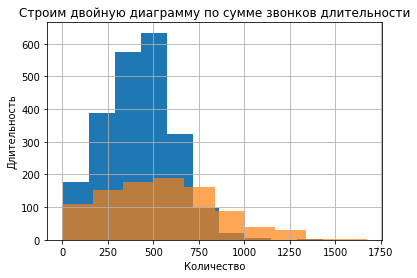

In [97]:
smart_call_sum = df_total_call_month_sum.query("tariff == 'smart'")
ultra_call_sum = df_total_call_month_sum.query("tariff == 'ultra'")

#y_month_sum = list(smart_call_sum.index.get_level_values(0))

smart_call_sum['call_sum'].plot(kind='hist', alpha=1, grid=True)
ultra_call_sum['call_sum'].plot(kind='hist', alpha=0.7, grid=True)
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.title('Строим двойную диаграмму по сумме звонков длительности')
plt.show()

**Строим двойную диаграмму по среднему арифметическому количества звонков**

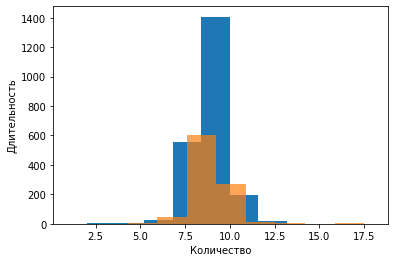

In [98]:
df_total_call_month_mean = df_total.groupby(['user_id','month',"tariff"]).agg({'call_mean':'sum'})
smart_call_mean = df_total_call_month_mean.query("tariff == 'smart'")
ultra_call_mean = df_total_call_month_mean.query("tariff == 'ultra'")
smart_call_mean['call_mean'].plot(kind='hist', alpha=1)
ultra_call_mean['call_mean'].plot(kind='hist', alpha=0.7)
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.show()

**Чтобы обращаться к месяцу как к обычному столбцу сделать в фрейме reset_index.**<a id="cell19"></a>

In [99]:
display(smart_call_mean.head())
display(smart_call_mean.reset_index().head())

call_mean
user_id month tariff           
1001    11    smart    9.555556
        12    smart    8.808511
1002    6     smart    8.357143
        7     smart   10.190476
        8     smart    7.810811

,user_id,month,tariff,call_mean
0,1001,11,smart,9.555556
1,1001,12,smart,8.808511
2,1002,6,smart,8.357143
3,1002,7,smart,10.190476
4,1002,8,smart,7.810811


In [100]:
# smart_call_mean1 = smart_call_mean.reset_index()
# ultra_call_mean1 = ultra_call_mean.reset_index()
# smart_call_mean1.plot(y = 'call_mean', x= 'month', kind='hist', alpha=1)
# ultra_call_mean1.plot(y = 'call_mean', x= 'month',kind='hist', alpha=0.7)
# plt.show()

In [101]:
display(smart_call_mean.head())
display(df_total_call_month_sum.head())
display(df_total_call_month_mean.head())


call_mean
user_id month tariff           
1001    11    smart    9.555556
        12    smart    8.808511
1002    6     smart    8.357143
        7     smart   10.190476
        8     smart    7.810811

call_sum
user_id month tariff          
1000    5     ultra        159
        6     ultra        172
        7     ultra        340
        8     ultra        408
        9     ultra        466

call_mean
user_id month tariff           
1000    5     ultra    9.352941
        6     ultra    6.142857
        7     ultra    8.292683
        8     ultra    9.714286
        9     ultra   10.130435

In [102]:
smart_call_sum['call_sum'].describe()

count    2221.000000
mean      419.440342
std       188.992403
min         2.000000
25%       285.000000
50%       423.000000
75%       546.000000
max      1435.000000
Name: call_sum, dtype: float64

In [103]:
ultra_call_sum['call_sum'].describe()

count     947.000000
mean      547.755016
std       305.513385
min         1.000000
25%       311.000000
50%       529.000000
75%       758.000000
max      1673.000000
Name: call_sum, dtype: float64

**Доступ к сводной таблице по индексу**<a id="cell28"></a>

In [104]:
display(df_total_call_month_sum.index.get_level_values(0))

Int64Index([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1001, 1001,
            ...
            1497, 1497, 1498, 1498, 1498, 1498, 1499, 1499, 1499, 1499], dtype='int64', name='user_id', length=3168)

<div class="alert alert-success" role="alert">
    <strong></strong> сколько сообщений
    </div>

**Строим двойную диаграмму по сумме смс**

In [105]:
df_total_mess_month_sum = df_total.groupby(['user_id', 'month','tariff']).agg({'mess_sum':'sum'})
display(df_total_mess_month_sum.head())

mess_sum
user_id month tariff          
1000    5     ultra       22.0
        6     ultra       60.0
        7     ultra       75.0
        8     ultra       81.0
        9     ultra       57.0

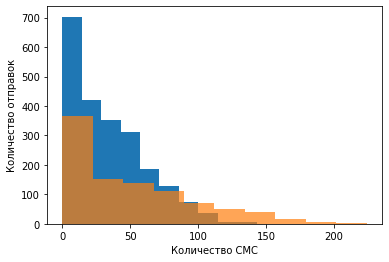

In [106]:
smart_mess = df_total_mess_month_sum.query("tariff == 'smart'")
ultra_mess = df_total_mess_month_sum.query("tariff == 'ultra'")

smart_mess['mess_sum'].plot(kind='hist', alpha=1)
ultra_mess['mess_sum'].plot(kind='hist', alpha=0.7)
plt.xlabel('Количество СМС')
plt.ylabel('Количество отправок')
plt.show()

#**Строим двойную диаграмму по  среднему арифметическому смс**

In [107]:
# df_total_mess_month_mean = df_total.groupby(['user_id', 'month','tariff']).agg({'mess_sum':'mean'})
# smart_mess_mean = df_total_mess_month_sum.query("tariff == 'smart'")
# ultra_mess_mean = df_total_mess_month_sum.query("tariff == 'ultra'")

# smart_mess_mean['mess_count'].plot(kind='hist', alpha=1)
# ultra_mess_mean['mess_count'].plot(kind='hist', alpha=0.7)
# plt.show()

<div class="alert alert-success" role="alert">
    <strong></strong> какой объём интернет-трафика
    </div>

**Строим двойную диаграмму по сумме трафика**

In [108]:
df_total_inter_month_sum = df_total.groupby(['user_id','month','tariff']).agg({'inter_sum':'sum'})
display(df_total_inter_month_sum.head())

inter_sum
user_id month tariff           
1000    5     ultra           3
        6     ultra          23
        7     ultra          14
        8     ultra          14
        9     ultra          15

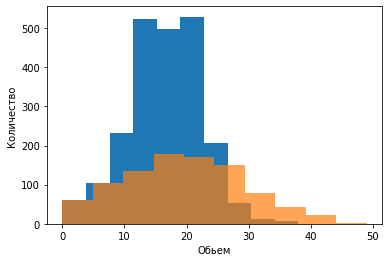

In [109]:
smart_inter = df_total_inter_month_sum.query("tariff == 'smart'")
ultra_inter = df_total_inter_month_sum.query("tariff == 'ultra'")

smart_inter['inter_sum'].plot(kind='hist', alpha=1)
ultra_inter['inter_sum'].plot(kind='hist', alpha=0.7)
plt.xlabel('Обьем')
plt.ylabel('Количество')
plt.show()

**Строим двойную диаграмму по сумме среднему арифметическому трафика**

In [110]:
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
0,0,1000,5,159,9.352941,3,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
1,1,1000,6,172,6.142857,23,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
2,2,1000,7,340,8.292683,14,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
3,3,1000,8,408,9.714286,14,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
4,4,1000,9,466,10.130435,15,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0


In [111]:
#df_total_inter_month_mean = df_total.groupby(['user_id','month','tariff']).agg({'inter_mean':'mean'})
df_total_inter_month_mean = df_total[['user_id','month','tariff','inter_mean']]
smart_inter_mean = df_total_inter_month_mean.query("tariff == 'smart'")
ultra_inter_mean = df_total_inter_month_mean.query("tariff == 'ultra'")


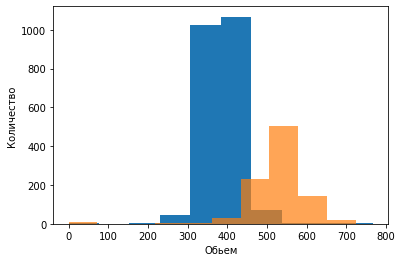

In [112]:
smart_inter_mean['inter_mean'].plot(kind='hist', alpha=1)
ultra_inter_mean['inter_mean'].plot(kind='hist', alpha=0.7)
plt.xlabel('Обьем')
plt.ylabel('Количество')
plt.show()

## Шаг 3. Проанализируйте данные

### 2. Посчитайте среднее количество, дисперсию и стандартное отклонение.

In [113]:
total_var_std = df_total.groupby(['tariff']).agg({'call_sum':['mean','median','var', 'std'], 'mess_sum':['mean','median','var', 'std'], 'inter_sum':['mean','median','var', 'std']})
total_var_std_ind = total_var_std.reset_index()
display(total_var_std_ind)

tariff    call_sum                                    mess_sum                                 inter_sum                            
                mean median           var         std       mean median          var        std       mean median        var       std
0  smart  419.440342    423  35718.128534  188.992403  33.392166   28.0   799.206047  28.270233  16.361999     17  33.223853  5.764014
1  ultra  547.755016    529  93338.428291  305.513385  48.759240   39.0  2171.726328  46.601785  19.529039     19  98.099314  9.904510

In [114]:
df_total['call_sum'].describe()

count    3168.000000
mean      457.797033
std       237.423514
min         1.000000
25%       290.750000
50%       447.500000
75%       592.250000
max      1673.000000
Name: call_sum, dtype: float64

###  Постройте гистограммы. Опишите распределения.

**Строим двойную диаграмму по сумме звонков длительности**

call_sum
user_id month tariff          
1001    11    smart        430
        12    smart        414
1002    6     smart        117
        7     smart        214
        8     smart        289

count    2221.000000
mean      419.440342
std       188.992403
min         2.000000
25%       285.000000
50%       423.000000
75%       546.000000
max      1435.000000
Name: call_sum, dtype: float64

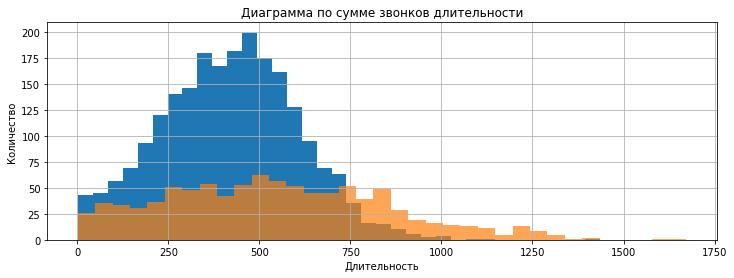

In [115]:
display(smart_call_sum.head())
display(smart_call_sum['call_sum'].describe())
smart_call_sum['call_sum'].plot(kind='hist', alpha=1,  grid=True, figsize=(12, 4), bins=35 )
ultra_call_sum['call_sum'].plot(kind='hist', alpha=0.7, grid=True, figsize=(12, 4), bins=35  )
plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.title('Диаграмма по сумме звонков длительности')
plt.show()

<div class = "alert alert-warning">
<h2> Комментарии ревьюера </h2>

Проверь корректность подписей осей

</div>

**Строим двойную диаграмму по сумме трафика**

count    947.000000
mean      19.529039
std        9.904510
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: inter_sum, dtype: float64

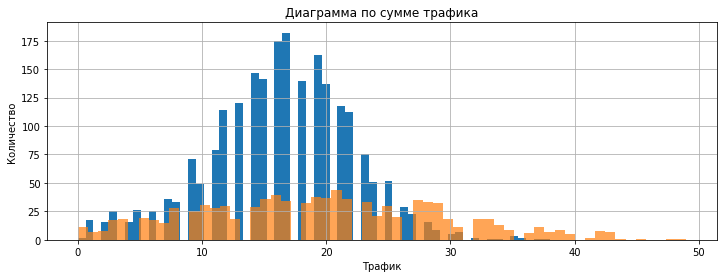

In [116]:
display(ultra_inter['inter_sum'].describe())
df_total_inter_month_sum = df_total.groupby(['user_id','month','tariff']).agg({'inter_sum':'sum'})
smart_inter['inter_sum'].plot(kind='hist', alpha=1, grid=True, figsize=(12, 4), bins=60 )
ultra_inter['inter_sum'].plot(kind='hist', alpha=0.7, grid=True, figsize=(12, 4), bins=60 )
plt.ylabel('Количество')
plt.xlabel('Трафик')
plt.title('Диаграмма по сумме трафика')
plt.show()

**Строим двойную диаграмму по сумме смс**

count    2221.000000
mean       33.392166
std        28.270233
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: mess_sum, dtype: float64

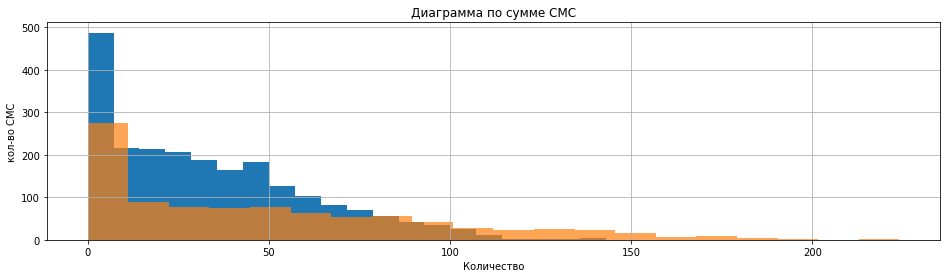

In [117]:
display(smart_mess['mess_sum'].describe())
smart_mess['mess_sum'].plot(kind='hist', alpha=1, grid=True,  figsize=(12, 4), bins=20 )
ultra_mess['mess_sum'].plot(kind='hist', alpha=0.7, grid=True,  figsize=(16, 4), bins=20 )
plt.xlabel('Количество')
plt.ylabel('кол-во СМС')
plt.title('Диаграмма по сумме СМС')
plt.show()

###  Общая выручка помесячно <a id="cell20"></a>

In [1]:
call_month_bill = df_total.groupby(['month','tariff']).agg({'total_bill':'sum'}).reset_index()
smart_bill_sum = call_month_bill.query("tariff == 'smart'")
ultra_bill_sum = call_month_bill.query("tariff == 'ultra'")
display(smart_bill_sum.head())

plt.plot(smart_bill_sum ['month'], smart_bill_sum ['total_bill'], '-r')
plt.plot(ultra_bill_sum ['month'], ultra_bill_sum ['total_bill'], '-g')

plt.figure(figsize=(12, 7))
#plt.plot(df_date['year_of_release'], df_date['total_sales'], '-r');
plt.title('Выручка по годам', fontsize=17, color='blue')
plt.xlabel('Года',fontsize=12, color='red')
plt.ylabel('Выручка млн.',fontsize=12, color='red')
plt.grid(True)
plt.show()

plt.show()
smart_bill_sum['total_bill'].min()
smart_bill_sum['total_bill'].max()

NameError: name 'df_total' is not defined

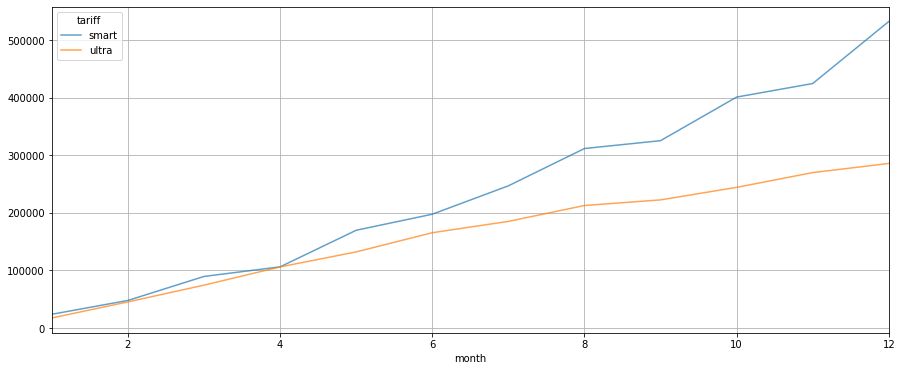

tariff,smart,ultra
month,,
1,23975.0,17550.0
2,48001.0,45450.0
3,89676.0,74550.0
4,106316.0,106200.0
5,169849.0,132300.0
6,197709.0,165600.0
7,247014.0,185250.0
8,311790.0,212850.0
9,325436.0,222600.0


In [119]:
df_total.pivot_table(index='month', values='total_bill', columns='tariff', aggfunc=sum).plot(alpha=0.7, grid=True, figsize=(15, 6))
plt.show()
dinamic_total_bill=df_total.pivot_table(index='month', values='total_bill', columns='tariff', aggfunc=sum)
display(dinamic_total_bill.head(12))

**Динамика подключивщихся пользователей по месяцам**

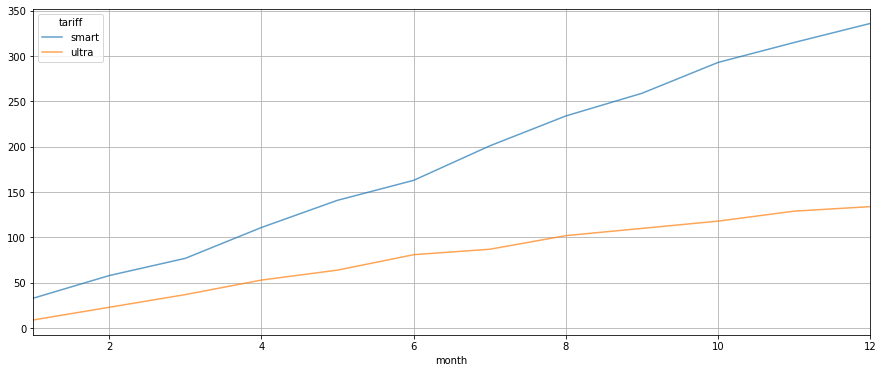

In [120]:
df_total.pivot_table(index='month', values='user_id', columns='tariff', aggfunc='count').plot(alpha=0.7, grid=True, figsize=(15, 6))
plt.show()

In [121]:
dinamic_user_id = df_total.pivot_table(index='month', values='user_id', columns='tariff', aggfunc='count')
display(dinamic_user_id.head() )

tariff,smart,ultra
month,,
1,33,9
2,58,23
3,77,37
4,111,53
5,141,64


**Считаем доход с кажного клиента помесячно для каждого из тарифоф**

In [122]:
dinamic_total = dinamic_total_bill.reset_index().merge(dinamic_user_id, on=['month'], how='left')
"""склеиваем таблицы с общей выручкой по месяцам с количеством подключившихся пользователей"""
#display(dinamic_total.head(10))
"""Делим общую выручку на количество пользователей помесячно узнаем сколько в месяц принес один пользователь с разных тарифов"""
dinamic_total['profit_smart_user'] = dinamic_total['smart_x']/dinamic_total['smart_y']
dinamic_total['profit_ultra_user'] = dinamic_total['ultra_x']/dinamic_total['ultra_y']
dinamic_total = dinamic_total.rename(columns={'smart_x':'profit_smart_month','ultra_x':'profit_ultra_month','smart_y':'sum_user_smart', 'ultra_y': 'sum_user_ultra'})
display(dinamic_total.head(10))

tariff,month,profit_smart_month,profit_ultra_month,sum_user_smart,sum_user_ultra,profit_smart_user,profit_ultra_user
0,1,23975.0,17550.0,33,9,726.515152,1950.000000
1,2,48001.0,45450.0,58,23,827.603448,1976.086957
2,3,89676.0,74550.0,77,37,1164.623377,2014.864865
3,4,106316.0,106200.0,111,53,957.801802,2003.773585
4,5,169849.0,132300.0,141,64,1204.602837,2067.187500
5,6,197709.0,165600.0,163,81,1212.938650,2044.444444
6,7,247014.0,185250.0,201,87,1228.925373,2129.310345
7,8,311790.0,212850.0,234,102,1332.435897,2086.764706
8,9,325436.0,222600.0,259,110,1256.509653,2023.636364
9,10,401117.0,244350.0,293,118,1369.000000,2070.762712


**Суммируем выручку с тарифа и абонента**

In [123]:
print('Выручка за год с тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_month'].sum()))
print('Выручка за год с тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_month'].sum()))
print('________________________________________________________________')
print()
print('Средняя выручка за год с тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_month'].mean()))
print('Средняя выручка за год с тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_month'].mean()))
print('________________________________________________________________')
print()
print('Выручка за год с одного абонента тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_user'].sum()))
print('Выручка за год с одного абонента тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_user'].sum()))
print('________________________________________________________________')
print()
print('Средняя выручка за год с одного абонента тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_user'].mean()))
print('Средняя выручка за год с одного абонента тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_user'].mean()))

Выручка за год с тарифа Смарт -  2877951 руб. 
Выручка за год с тарифа Ультра - 1962600 руб. 
________________________________________________________________

Средняя выручка за год с тарифа Смарт -  239829 руб. 
Средняя выручка за год с тарифа Ультра - 163550 руб. 
________________________________________________________________

Выручка за год с одного абонента тарифа Смарт -  14214 руб. 
Выручка за год с одного абонента тарифа Ультра - 24593 руб. 
________________________________________________________________

Средняя выручка за год с одного абонента тарифа Смарт -  1184 руб. 
Средняя выручка за год с одного абонента тарифа Ультра - 2049 руб. 


<div class="alert alert-info">
    <strong>до исправления системы подсчета</strong> </div>

Выручка за год с тарифа Смарт -  2385844 руб.  
Выручка за год с тарифа Ультра - 1528519 руб. 
________________________________________________________________

Средняя выручка за год с тарифа Смарт -  198820 руб.  
Средняя выручка за год с тарифа Ультра - 127377 руб. 
________________________________________________________________

Выручка за год с одного абонента тарифа Смарт -  11880 руб.  
Выручка за год с одного абонента тарифа Ультра - 18567 руб. 
________________________________________________________________

Средняя выручка за год с одного абонента тарифа Смарт -  990 руб.  
Средняя выручка за год с одного абонента тарифа Ультра - 1547 руб. 

## Выводы:
### Опишите поведение клиентов оператора, исходя из выборки. 
### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
### Опишите распределения.
### Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<div class="alert alert-info">
    <strong>проанализировать дисперсию и распределения 
    доход на одного клиента</strong> </div>

**Исходя из средних значений и  медиан мы видим:**
- Средняя продолжительность разговора выше на тарифе "Ультра" примерно на 20%
- Кличество смс на тарифе "Ультра" выше почти на 50-60%
- Также количество интеренет трафика не намного больше в среднем на тарифе "Ультра" примерно на 10%
- Средние и медианы отличаются не очень сильно , что говорит об отсутствии большого количества выбросов
- По стандартному отклонению мы видим большое отклонение от среднего во всех наших выборках, что возможно происходит это из за того что ежемесячно был прирост клиентской базы

**По диаграммам можно сделать выводы:**

**Звонки:**
- Наиболее распостранена длительность на тарифе "Смарт" 450-500 минут разговоров в месяц и в случае тарифа "Ультра" наибольшая длительность очень растянута и достигает от 250 - 800 минут достигая небольшого пика в 500 мин
- На тарифе "Ультра клиенты раговаривают дольше чем на "Смарте"

**СМС:**
- В основном клиенты отправляют не очень большшое количество смс для обоих тарифов это до 50 в месяц
- На тарифе "Ультра" есть небоьшое количество клиентов отправляющие более 120 смс

**Потребляемый интеренет траффик:**
- Наибольшее количество клиентов тарифа "Смарт" потребляют 15 - 20 Гб в месяц, для тарифа "Ультра" этот показатель ровно распределяется от 10 до 30 Гб
- Максимальное количество потребляемого трафика на тарифе "Ультра" гораздо выше


**По графику прироста абонентов мы видим как компания в течении года  наращивала базу абонентов.**
- Прирост клиентов на тарифе смарт больше потому что он дешевле и доступен более широкому кругу абонентов

**График получение выручки с каждого тарифа**
- Не смотря что стоимость тарифа Ультра выше получаемая общая выручка с него меньще за счет меньщего количества абонентов

**График получение выручки с каждого абонента**
- Абонент тарифа Ультра ежемесячно и всего в год приносит выручки больше чем абонент тарифа Смарт. Годовая выручка с одного абонента тарифа Ультра почти в 2 раза больше чем с абонента тарифа Смарт



## Шаг 4. Проверьте гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

<div class="alert alert-success" role="alert">
  <strong> Проверяем гипотезу двух стороннию  что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; проверим на полной генеральной совокупности</strong> 
    
    - Формируем нулевую и альтернатвную гипотезу исходя из задания:
    Нулевая гипотеза: так как Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства 
    То формулируем ее так: 
                               Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны;
    Исходя из нулевой гипотезы 
    Альтернативная гипотеза:   
                               Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; 
</div>

<div class="alert alert-success">
<h2> Комментарий от ревьюера </h2>

Отлично, гипотезы сформулированы правильно

</div>

In [124]:
df_total.head()

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
0,0,1000,5,159,9.352941,3,564.000000,22.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
1,1,1000,6,172,6.142857,23,528.568182,60.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
2,2,1000,7,340,8.292683,14,500.571429,75.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
3,3,1000,8,408,9.714286,14,521.111111,81.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0
4,4,1000,9,466,10.130435,15,583.240000,57.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0,0.0,0.0,1950.0


In [125]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 21 columns):
index                    3168 non-null int64
user_id                  3168 non-null int64
month                    3168 non-null int64
call_sum                 3168 non-null int64
call_mean                3168 non-null float64
inter_sum                3168 non-null int64
inter_mean               3168 non-null float64
mess_sum                 3168 non-null float64
city                     3168 non-null object
tariff                   3168 non-null object
messages_included        3168 non-null int64
mb_per_month_included    3168 non-null float64
minutes_included         3168 non-null int64
rub_monthly_fee          3168 non-null int64
rub_per_mb               3168 non-null int64
rub_per_message          3168 non-null int64
rub_per_minute           3168 non-null int64
minutes_paid             3168 non-null int64
internet_paid            3168 non-null float64
message_paid             3

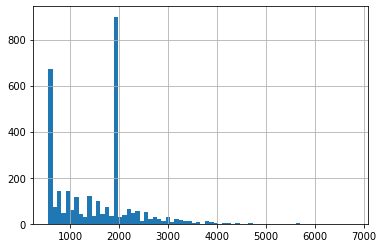

In [126]:
df_total['total_bill'].hist(bins=70);

In [127]:
df_total['total_bill'].describe()

count    3168.000000
mean     1527.951705
std       802.304167
min       550.000000
25%       750.000000
50%      1635.500000
75%      1950.000000
max      6770.000000
Name: total_bill, dtype: float64

<div class="alert alert-info" role="alert">
    <strong>смотрим сколько пустых значений в 'total_bill' <strong> 
    </div>

In [128]:
#df_total['total_bill'].isna().sum() 

<div class="alert alert-info" role="alert">
    <strong>меняем пустые на ноль</strong> 
    </div>

In [129]:
#df_total['total_bill'].fillna(0, inplace=True)

In [130]:
#df_total['total_bill'].isna().sum() 

**Выделяем из общей таблицы выручку пользователей тарифа Ультра**

In [131]:
df_gipoteza_mean_bill_ultra = df_total[df_total['tariff'] == 'ultra']

df_gipoteza_mean_bill_ultra = df_gipoteza_mean_bill_ultra['total_bill']
display(df_gipoteza_mean_bill_ultra.head())


0    1950.0
1    1950.0
2    1950.0
3    1950.0
4    1950.0
Name: total_bill, dtype: float64

**Выделяем из общей таблицы выручку пользователей тарифа Смарт**

**interested_value предполагаемое среднее, на равенство которому мы делаем тест.**  
берем среднее тарифа смарт

In [132]:
df_gipoteza_mean_bill_smart = df_total[df_total['tariff'] == 'smart']
df_gipoteza_mean_bill_smart_mean = df_gipoteza_mean_bill_smart['total_bill'].mean()
display(df_gipoteza_mean_bill_smart_mean)
display(df_gipoteza_mean_bill_ultra.mean())

1295.790634849167

2072.4392819429777

In [133]:
interested_value = 1295.24
    
alpha = .05 # критический уровень статистической значимости
    
results = st.ttest_1samp(
    df_gipoteza_mean_bill_ultra, 
    interested_value)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0
Отвергаем нулевую гипотезу


<div class="alert alert-success">
<h2> Комментарий от ревьюера </h2>

Похвально, что проводишь проверку доп-но по `ttest_1samp`

</div>

**Гипотеза не подтвердилать что и потдверждают наши вычесленные значения средних**

<div class="alert alert-success" role="alert">
    <strong>Используем Гипотезу о равенстве средних двух генеральных совокупностей</strong> 
    </div>

**Выделяем из общей таблицы выручку пользователей тарифа Смарт**

In [134]:
df_gipoteza_mean_bill_smart = df_total[df_total['tariff'] == 'smart']
df_gipoteza_mean_bill_smart = df_gipoteza_mean_bill_smart['total_bill']
display(df_gipoteza_mean_bill_smart.head())


8     1350.0
9      550.0
10     550.0
11    1150.0
12    1550.0
Name: total_bill, dtype: float64

In [135]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_gipoteza_mean_bill_ultra, 
    df_gipoteza_mean_bill_smart)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.399451579946976e-152
Отвергаем нулевую гипотезу


<div class="alert alert-success" role="alert">
  <strong> Проверяем гипотезу двух стороннию  что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; проверим на выборке из 50 элементов как учили на курсе</strong>   
</div>

**Берем срезы по 50 элементов из обоих выборок**

In [136]:
df_gipoteza_mean_bill_smart_50 = df_gipoteza_mean_bill_smart[1 : 51]
df_gipoteza_mean_bill_ultra_50 = df_gipoteza_mean_bill_ultra[25:76]

In [137]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_gipoteza_mean_bill_ultra_50, 
    df_gipoteza_mean_bill_smart_50)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.988401027881495e-23
Отвергаем нулевую гипотезу


**Гипотеза также не подтвердилась**

<div class="alert alert-success" role="alert">
  <strong> Проверяем гипотезу что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов проверим сразу на срезах из 50 элементов;</strong> 
    
    - Формируем нулевую и альтернатвную гипотезу исходя из задания:
    Нулевая гипотеза: так как Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства 
    То формулируем ее так: 
                       Средняя выручка пользователей из Москвы равна от выручки пользователей из других регионов;
    Исходя из нулевой гипотезы 
    Альтернативная гипотеза:   
                       Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов; 
</div>

**Формируем таблицу из Московских абонентов берем выборку из 50 элементов**

In [138]:
df_total['city'].value_counts().head()

Москва             610
Санкт-Петербург    262
Новосибирск         98
Уфа                 95
Краснодар           86
Name: city, dtype: int64

In [139]:
df_gipoteza_city_msk = df_total[df_total['city'] == 'Москва']
df_gipoteza_city_msk = df_gipoteza_city_msk['call_sum']
#df_gipoteza_city_msk_50 = df_gipoteza_city_msk[200:251]
display(df_gipoteza_city_msk.head())

8     430
9     414
17    380
18    961
19    855
Name: call_sum, dtype: int64

**Формируем таблицу из пользователей из других регионов и берем выборку из 50 элементов**

In [140]:
df_gipoteza_city_not_msk = df_total[df_total['city'] != 'Москва']
df_gipoteza_city_not_msk = df_gipoteza_city_not_msk['call_sum']
#df_gipoteza_city_not_msk_50 = df_gipoteza_city_not_msk[2000:2051]
display(df_gipoteza_city_not_msk.head())

0    159
1    172
2    340
3    408
4    466
Name: call_sum, dtype: int64

In [141]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_gipoteza_city_msk, 
    df_gipoteza_city_not_msk)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.16053237424460431
Не получилось отвергнуть нулевую гипотезу


**Проверим обычны спсобом**

**сначала срезы**

In [142]:
#df_gipoteza_city_not_msk[2000:2051].describe()

In [143]:
#df_gipoteza_city_msk[200:251].describe()

**полные выборки**

In [144]:
df_gipoteza_city_msk_not_full_sum = df_total[df_total['city'] != 'Москва']
df_gipoteza_city_msk_not_full_sum['call_sum'].describe()

count    2558.000000
mean      454.906177
std       236.522598
min         1.000000
25%       289.000000
50%       445.000000
75%       586.750000
max      1673.000000
Name: call_sum, dtype: float64

In [145]:
df_gipoteza_city_msk_full_sum = df_total[df_total['city'] == 'Москва']
df_gipoteza_city_msk_full_sum['call_sum'].describe()

count     610.000000
mean      469.919672
std       240.983327
min         1.000000
25%       305.000000
50%       453.000000
75%       621.250000
max      1321.000000
Name: call_sum, dtype: float64

**гипотеза возможно подтверждена**

# Шаг 5. Oбщий вывод

### При обработке данных: 
#### - Исправлен формат даты, в данных смс заменены пропуски данных на нули
Рекомендации:
- вносить дату в правильном формате
- в случае нулевого количества смс вносить ноль а не оставлять пропуск

#### - При анализе данных выявленно:
- Средняя продолжительность разговора выше на тарифе "Ультра" примерно на 20%
- Кличество смс на тарифе "Ультра" выше почти на 50-60%
- Также количество интеренет трафика не намного больше в среднем на тарифе "Ультра" примерно на 10%
- Наиболее распостранена длительность на тарифе "Смарт" 450-500 минут разговоров в месяц и в случае тарифа "Ультра" наибольшая длительность очень растянута и достигает от 250 - 800 минут достигая небольшого пика в 500 мин
- На тарифе "Ультра клиенты раговаривают дольше чем на "Смарте"
- В основном клиенты отправляют не очень большшое количество смс для обоих тарифов это до 10 в месяц
- Наибольшее количество клиентов тарифа "Смарт" потребляют 15 - 20 Гб в месяц, для тарифа "Ультра" этот показатель ровно распределяется от 10 до 30 Гб
Рекомендации:
- мы видим что 3000 минут на тарифе смарт явно избыточное предоложение и может быть сокращено без ущерба для пользователей
впрочем судя по стабильному наращиванию клиентской базы возможно данное предложение дает неплохую привлекательность и немять ее не стоит чтобы не отпугнуть клиентов
- может быть стоит увеличить количество бесплатного траффика до 35 Гб сделав тариф более привлекательным для абонентов потребляющих большое количество трафика.
#### Проверка гипотез:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; **Подтвердилась**
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов; **Не подтвердилась**
## Вывод: 
#### Оба тарифа приносят прибыль, в расчете на одного клиента прибыль тарифа Ультра выше, но валовую выручку больше приносит тариф смарт.  
#### Тарифы  исходя из разницы количества пользователей используют абоненты разных целевых аудиторий, например с разным уровнем дохода. 
####  не целесобразно закрывать ни один из тарифов.
#### Рекомендации:

- мы видим что 3000 минут на тарифе смарт явно избыточное предоложение и может быть сокращено без ущерба для пользователей
впрочем судя по стабильному наращиванию клиентской базы возможно данное предложение дает неплохую привлекательность и менять ее не стоит чтобы не отпугнуть клиентов
- может быть стоит увеличить количество бесплатного траффика до 35 Гб сделав в тарифе Ультра тариф более привлекательным для абонентов потребляющих большое количество трафика.
- Также судя по средней выручке в МСК и регионах рекомендуется углубить экспансию в регионы которые в среднем приносят сравнимую с МСК прибыль.